In [1]:
import itertools
import pandas as pd
import numpy as np
import warnings
import sklearn.metrics as skm
import seaborn as sns
import sklearn.datasets as skd
#import kditransform
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from tabpfn import TabPFNClassifier
from sklearn.utils import check_random_state

import condo

rng = np.random.RandomState(0)

In [13]:
dataset = skd.fetch_california_housing()
X_full, y_full = dataset.data, dataset.target
feats = dataset.feature_names
print(feats)

median_y = 1.797  # np.median(y_full)
assert median_y == np.median(y_full)

source_samples = 500
target_samples = 500
num_random = 10
methods = [
    'Gaussian OT', 'MMD', 
    'Gaussian OT w/o LatLon', 'MMD w/o LatLon',
    'ConDo Gaussian KLD', 'ConDo MMD',
]

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


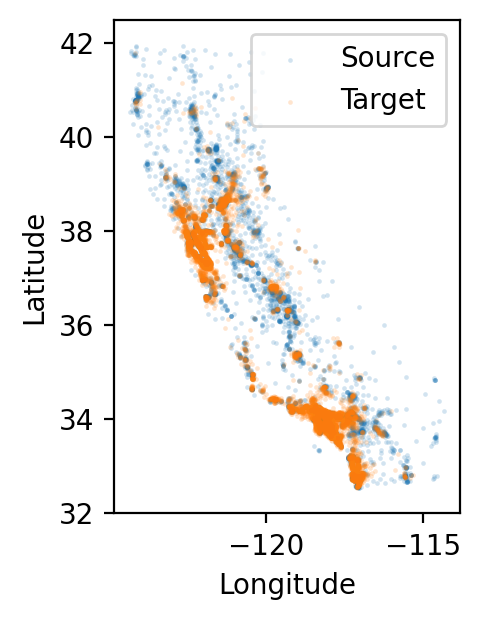

In [30]:
source = X_full[:, feats.index('MedInc')] <= np.median(X_full[:, feats.index('MedInc')])
target = X_full[:, feats.index('MedInc')] > np.median(X_full[:, feats.index('MedInc')])
X_source = X_full[source, :]
X_target = X_full[target, :]
y_source = y_full[source]
y_target = y_full[target]

plt.figure(figsize=(2.5,3.2), dpi=200);
plt.scatter(
    X_full[source, feats.index('Longitude')],
    X_full[source, feats.index('Latitude')],
    s=2.8, alpha=0.2, linewidth=0, label='Source');
plt.scatter(
    X_full[target, feats.index('Longitude')],
    X_full[target, feats.index('Latitude')],
    s=2.8, alpha=0.2, linewidth=0, label='Target');
plt.legend();
plt.ylim(32, 42.5);
plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.tight_layout();
plt.savefig('ca-housing-income.png');

In [4]:
acc_dict = {
    'HighIncome (source - train)': [],
    'HighIncome (source - test)': [],
    'LowIncome (target - no adaptation)': [],
    'Gaussian OT': [],
    'MMD': [],
    'ConDo Gaussian KLD': [],
    'ConDo MMD': [],
    'Gaussian OT w/o LatLon': [],
    'MMD w/o LatLon': [],
    'ConDo Gaussian KLD w/o LatLon': [],
    'ConDo MMD w/o LatLon': [],
}
f1_dict = {
    'HighIncome (source - train)': [],
    'HighIncome (source - test)': [],
    'LowIncome (target - no adaptation)': [],
    'Gaussian OT': [],
    'MMD': [],
    'ConDo Gaussian KLD': [],
    'ConDo MMD': [],
    'Gaussian OT w/o LatLon': [],
    'MMD w/o LatLon': [],
    'ConDo Gaussian KLD w/o LatLon': [],
    'ConDo MMD w/o LatLon': [],
}

adapterGaussianOT = condo.AdapterGaussianOT(transform_type='location-scale')
adapterGaussianOT.fit(
    X_target[:, feats.index('MedInc')+1:],
    X_source[:, feats.index('MedInc')+1:]);
adapterAdapterMMD = condo.AdapterMMD(transform_type='location-scale', verbose=0)
adapterAdapterMMD.fit(
    X_target[:, feats.index('MedInc')+1:],
    X_source[:, feats.index('MedInc')+1:]);    
adapterConDoAdapterKLD = condo.ConDoAdapterKLD(transform_type='location-scale')
adapterConDoAdapterKLD.fit(
    X_target[:, feats.index('MedInc')+1:], 
    X_source[:, feats.index('MedInc')+1:],
    X_target[:, [feats.index('Latitude'), feats.index('Longitude')]], 
    X_source[:, [feats.index('Latitude'), feats.index('Longitude')]]);
adapterConDoAdapterMMD = condo.ConDoAdapterMMD(transform_type='location-scale', verbose=0)
adapterConDoAdapterMMD.fit(
    X_target[:, feats.index('MedInc')+1:], 
    X_source[:, feats.index('MedInc')+1:],
    X_target[:, [feats.index('Latitude'), feats.index('Longitude')]], 
    X_source[:, [feats.index('Latitude'), feats.index('Longitude')]]);

adapterGaussianOTwoLL = condo.AdapterGaussianOT(transform_type='location-scale')
adapterGaussianOTwoLL.fit(
    X_target[:, feats.index('MedInc')+1:feats.index('Latitude')],
    X_source[:, feats.index('MedInc')+1:feats.index('Latitude')]);
adapterAdapterMMDwoLL = condo.AdapterMMD(transform_type='location-scale', verbose=0)
adapterAdapterMMDwoLL.fit(
    X_target[:, feats.index('MedInc')+1:feats.index('Latitude')],
    X_source[:, feats.index('MedInc')+1:feats.index('Latitude')]);    
adapterConDoAdapterKLDwoLL = condo.ConDoAdapterKLD(transform_type='location-scale')
adapterConDoAdapterKLDwoLL.fit(
    X_target[:, feats.index('MedInc')+1:feats.index('Latitude')], 
    X_source[:, feats.index('MedInc')+1:feats.index('Latitude')],
    X_target[:, [feats.index('Latitude'), feats.index('Longitude')]], 
    X_source[:, [feats.index('Latitude'), feats.index('Longitude')]]);
adapterConDoAdapterMMDwoLL = condo.ConDoAdapterMMD(transform_type='location-scale', verbose=0)
adapterConDoAdapterMMDwoLL.fit(
    X_target[:, feats.index('MedInc')+1:feats.index('Latitude')], 
    X_source[:, feats.index('MedInc')+1:feats.index('Latitude')],
    X_target[:, [feats.index('Latitude'), feats.index('Longitude')]], 
    X_source[:, [feats.index('Latitude'), feats.index('Longitude')]]);

for rix in range(num_random):
    rng = check_random_state(rix)
    source_ixs = rng.choice(X_source.shape[0], size=source_samples*2, replace=False)
    source_train_ixs = source_ixs[0:source_samples]
    source_test_ixs = source_ixs[source_samples:]
    target_test_ixs = rng.choice(X_target.shape[0], size=target_samples, replace=False)
    X_source_train = X_source[source_train_ixs, :]
    X_source_test = X_source[source_test_ixs, :]
    X_target_test = X_target[target_test_ixs, :]
    y_source_train = y_source[source_train_ixs]
    y_source_test = y_source[source_test_ixs]
    y_target_test = y_target[target_test_ixs]

    clf = TabPFNClassifier().fit(
        X_source_train[:, feats.index('MedInc')+1:],
        (y_source_train > median_y)
    )

    pred = clf.predict(X_source_train[:, feats.index('MedInc')+1:])
    acc = skm.accuracy_score(pred, (y_source_train > median_y))
    f1 = skm.f1_score(pred, (y_source_train > median_y))
    acc_dict['HighIncome (source - train)'].append(acc)
    f1_dict['HighIncome (source - train)'].append(f1)

    pred = clf.predict(X_source_test[:, feats.index('MedInc')+1:])
    acc = skm.accuracy_score(pred, (y_source_test > median_y))
    f1 = skm.f1_score(pred, (y_source_test > median_y))
    acc_dict['HighIncome (source - test)'].append(acc)
    f1_dict['HighIncome (source - test)'].append(f1)

    pred = clf.predict(X_target_test[:, feats.index('MedInc')+1:])
    acc = skm.accuracy_score(pred, (y_target_test > median_y))
    f1 = skm.f1_score(pred, (y_target_test > median_y))
    acc_dict['LowIncome (target - no adaptation)'].append(acc)
    f1_dict['LowIncome (target - no adaptation)'].append(f1)

    X_target_test_adapt = adapterGaussianOT.transform(
        X_target_test[:, feats.index('MedInc')+1:])
    pred = clf.predict(X_target_test_adapt)
    acc = skm.accuracy_score(pred, (y_target_test > median_y))
    f1 = skm.f1_score(pred, (y_target_test > median_y))
    acc_dict[f'Gaussian OT'].append(acc)
    f1_dict[f'Gaussian OT'].append(f1)

    X_target_test_adapt = adapterAdapterMMD.transform(
        X_target_test[:, feats.index('MedInc')+1:])
    pred = clf.predict(X_target_test_adapt)
    acc = skm.accuracy_score(pred, (y_target_test > median_y))
    f1 = skm.f1_score(pred, (y_target_test > median_y))
    acc_dict[f'MMD'].append(acc)
    f1_dict[f'MMD'].append(f1)

    X_target_test_adapt = adapterConDoAdapterKLD.transform(
        X_target_test[:, feats.index('MedInc')+1:])
    pred = clf.predict(X_target_test_adapt)
    acc = skm.accuracy_score(pred, (y_target_test > median_y))
    f1 = skm.f1_score(pred, (y_target_test > median_y))
    acc_dict[f'ConDo Gaussian KLD'].append(acc)
    f1_dict[f'ConDo Gaussian KLD'].append(f1)

    X_target_test_adapt = adapterConDoAdapterMMD.transform(
        X_target_test[:, feats.index('MedInc')+1:])
    pred = clf.predict(X_target_test_adapt)
    acc = skm.accuracy_score(pred, (y_target_test > median_y))
    f1 = skm.f1_score(pred, (y_target_test > median_y))
    acc_dict[f'ConDo MMD'].append(acc)
    f1_dict[f'ConDo MMD'].append(f1)

    X_target_test_adapt = adapterGaussianOTwoLL.transform(
        X_target_test[:, feats.index('MedInc')+1:feats.index('Latitude')])
    pred = clf.predict(np.hstack([X_target_test_adapt, X_target_test[:,feats.index('Latitude'):]]))
    acc = skm.accuracy_score(pred, (y_target_test > median_y))
    f1 = skm.f1_score(pred, (y_target_test > median_y))
    acc_dict[f'Gaussian OT w/o LatLon'].append(acc)
    f1_dict[f'Gaussian OT w/o LatLon'].append(f1)

    X_target_test_adapt = adapterAdapterMMDwoLL.transform(
        X_target_test[:, feats.index('MedInc')+1:feats.index('Latitude')])
    pred = clf.predict(np.hstack([X_target_test_adapt, X_target_test[:,feats.index('Latitude'):]]))
    acc = skm.accuracy_score(pred, (y_target_test > median_y))
    f1 = skm.f1_score(pred, (y_target_test > median_y))
    acc_dict[f'MMD w/o LatLon'].append(acc)
    f1_dict[f'MMD w/o LatLon'].append(f1)

    X_target_test_adapt = adapterConDoAdapterKLDwoLL.transform(
        X_target_test[:, feats.index('MedInc')+1:feats.index('Latitude')])
    pred = clf.predict(np.hstack([X_target_test_adapt, X_target_test[:,feats.index('Latitude'):]]))
    acc = skm.accuracy_score(pred, (y_target_test > median_y))
    f1 = skm.f1_score(pred, (y_target_test > median_y))
    acc_dict[f'ConDo Gaussian KLD w/o LatLon'].append(acc)
    f1_dict[f'ConDo Gaussian KLD w/o LatLon'].append(f1)

    X_target_test_adapt = adapterConDoAdapterMMDwoLL.transform(
        X_target_test[:, feats.index('MedInc')+1:feats.index('Latitude')])
    pred = clf.predict(np.hstack([X_target_test_adapt, X_target_test[:,feats.index('Latitude'):]]))
    acc = skm.accuracy_score(pred, (y_target_test > median_y))
    f1 = skm.f1_score(pred, (y_target_test > median_y))
    acc_dict[f'ConDo MMD w/o LatLon'].append(acc)
    f1_dict[f'ConDo MMD w/o LatLon'].append(f1)

/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

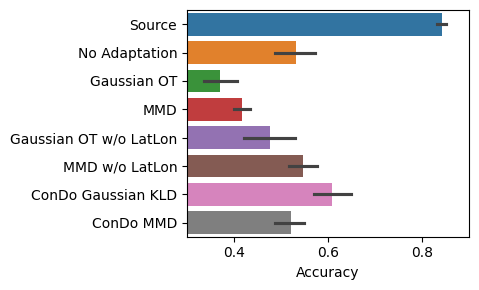

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3));
pacc_dict = {}
pacc_dict['Source'] = acc_dict['HighIncome (source - test)']
pacc_dict['No Adaptation'] = acc_dict['LowIncome (target - no adaptation)']
pacc_dict.update({key: acc_dict[key] for key in methods})
sns.barplot(pacc_dict, orient='h', ax=axes);
axes.set_xlabel('Accuracy');
#axes.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]);
plt.xlim(0.3, 0.9);
plt.tight_layout();
plt.savefig('cahousing-acc-lowinc2highinc.pdf');

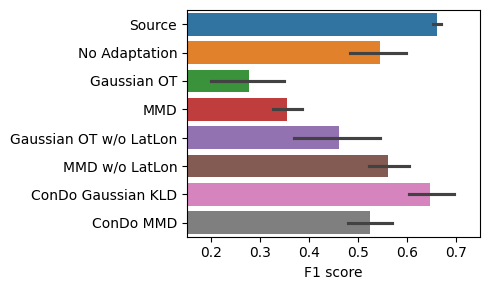

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3));
pf1_dict = {}
pf1_dict['Source'] = f1_dict['HighIncome (source - test)']
pf1_dict['No Adaptation'] = f1_dict['LowIncome (target - no adaptation)']
pf1_dict.update({key: f1_dict[key] for key in methods})

sns.barplot(pf1_dict, orient='h', ax=axes);
axes.set_xlabel('F1 score');
plt.xlim(0.15, 0.75);
plt.tight_layout();
plt.savefig('cahousing-f1-lowinc2highinc.pdf');

<Axes: >

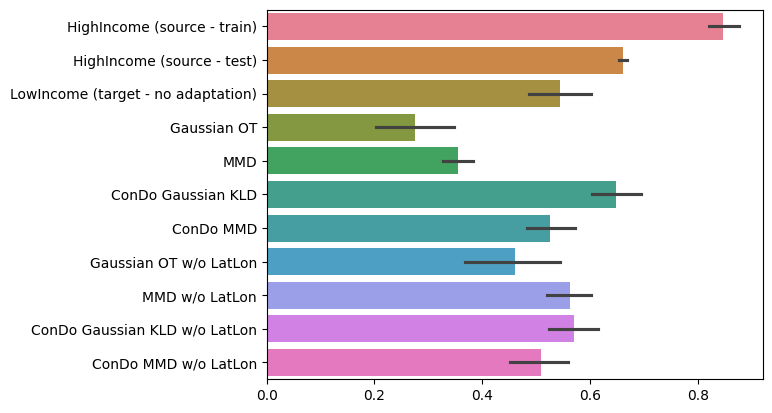

In [7]:
sns.barplot(f1_dict, orient='h')

<Axes: >

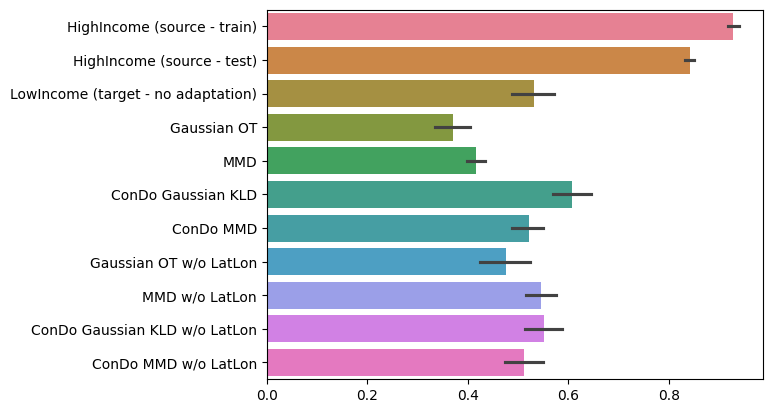

In [9]:
sns.barplot(acc_dict, orient='h')